# 8 - Large Spheres

**Scott Prahl**

**7 Feb 2019, Version 1**

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import miepython as mp

In [30]:
def Qabs_adt(m,x):
    n = np.real(m)
    kappa = -np.imag(m)
    if kappa == 0:
        return np.zeros_like(x)
    return 1+2*np.exp(-4*kappa*x)/(4*kappa*x)+2*(np.exp(-4*kappa*x)-1)/(4*kappa*x)**2

def Qabs_madt(m,x):
    n = np.real(m)
    kappa = -np.imag(m)
    if kappa == 0:
        return np.zeros_like(x)
    
    qabs_adt = Qabs_adt(m,x)
    epsilon = 0.25 + 0.61*(1-np.exp(-8*np.pi/3*kappa))**2
    c1 = 0.25*(1+np.exp(-1167*kappa))*(1-qabs_adt)
    c2 = np.sqrt(2*epsilon*x/np.pi)*np.exp(0.5-epsilon*x/np.pi)*(0.7393*n-0.6069)
    return (1+c1+c2)*qabs_adt

def Qext_adt(m,x):
    rho = 2*x*np.abs(m-1)
    beta = np.arctan2(kappa,n-1)

    qext_adt = 2
    qext_adt += -4*ex*np.cos(beta)/rho*np.sin(rho-beta)
    qext_adt += -4*ex*np.cos(beta)**2/rho**2*np.cos(rho-2*beta)
    qext_adt += 4*np.cos(beta)**2/rho**2*np.cos(2*beta)
    return qext_adt


def Qext_madt(m,x):
    n = np.real(m)
    kappa = -np.imag(m)
    
    qext_adt = Qext_adt(m,x)
    epsilon = 0.25 + 0.61*(1-np.exp(-8*np.pi/3*kappa))**2
    c2 = np.sqrt(2*epsilon*x/np.pi)*np.exp(0.5-epsilon*x/np.pi)*(0.7393*n-0.6069)
    Qedge = (1-np.exp(-0.06*x))*x**(-2/3)

    return (1+0.5*c2)*qext_adt+Qedge

## Three test cases

No absorption, a little absorption, a lot of absorption

Thanks to

### No Absorption m=1.5

In [39]:
m = 1.5
x = np.logspace(-1, 5, 50)  # also in microns
qext, qsca, qback, g = mp.mie(m,x)
qabs = qext-qsca

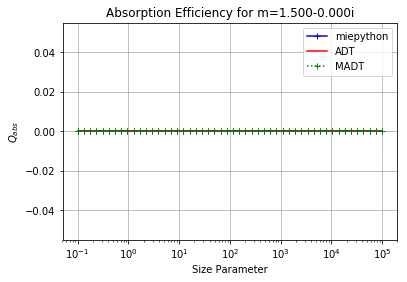

In [40]:
plt.semilogx(x, qabs, 'b-+', label="miepython")
plt.semilogx(x, Qabs_adt(m,x), 'r', label="ADT")
plt.semilogx(x, Qabs_madt(m,x), 'g+:', label="MADT")

plt.ylabel("$Q_{abs}$")

plt.xlabel("Size Parameter")
plt.title("Absorption Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

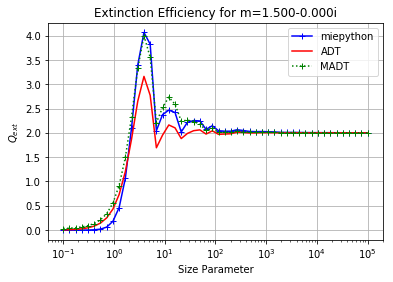

In [41]:
plt.semilogx(x, qext, 'b-+', label="miepython")
plt.semilogx(x, Qext_adt(m,x), 'r', label="ADT")
plt.semilogx(x, Qext_madt(m,x), 'g+:', label="MADT")

plt.ylabel("$Q_{ext}$")

plt.xlabel("Size Parameter")
plt.title("Extinction Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

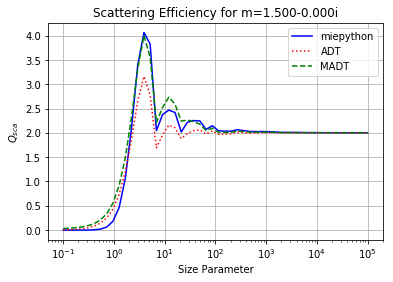

In [54]:
Qsca_adt = Qext_adt(m,x)-Qabs_adt(m,x)
Qsca_madt = Qext_madt(m,x)-Qabs_madt(m,x)

plt.semilogx(x, qsca, 'b', label="miepython")
plt.semilogx(x, Qsca_adt, 'r:', label="ADT")
plt.semilogx(x, Qsca_madt, 'g--', label="MADT")

plt.xlabel("Size Parameter")
plt.ylabel("$Q_{sca}$")
plt.title("Scattering Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

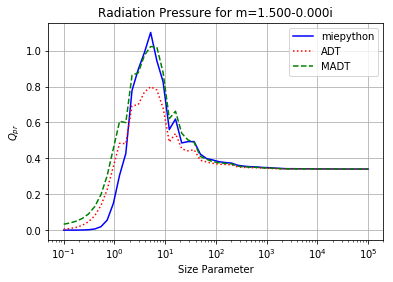

In [53]:
Qpr_adt = Qext_adt(m,x)-g*Qsca_adt
Qpr_madt = Qext_madt(m,x)-g*Qsca_madt

plt.semilogx(x, qext - g * qsca, 'b', label="miepython")
plt.semilogx(x, Qpr_adt, 'r:', label="ADT")
plt.semilogx(x, Qpr_madt, 'g--', label="MADT")


plt.xlabel("Size Parameter")
plt.ylabel("$Q_{pr}$")
plt.title("Radiation Pressure for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

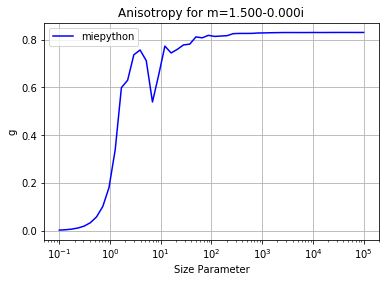

In [55]:
plt.semilogx(x, g, 'b', label="miepython")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Anisotropy for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

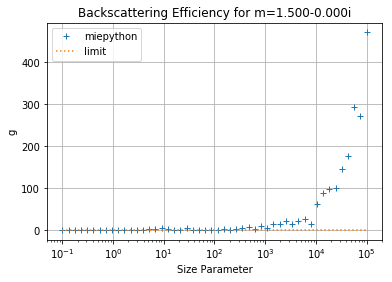

In [58]:
Qbacks = ((n-1)**2 + kappa**2)/((n+1)**2+kappa**2)
Qback = Qbacks * np.ones_like(x)

plt.semilogx(x, qback, '+', label="miepython")
plt.semilogx(x, Qback, ':', label="limit")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Backscattering Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

### Some Absorption m=1.5-0.001j

In [66]:
m = 1.5-0.001j
x = np.logspace(-1, 5, 50)  # also in microns
qext, qsca, qback, g = mp.mie(m,x)
qabs = qext-qsca

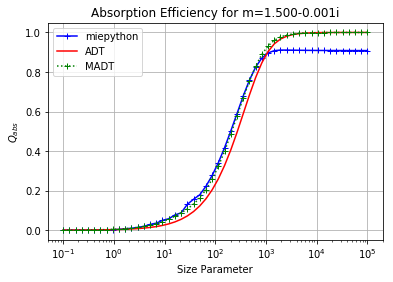

In [67]:
plt.semilogx(x, qabs, 'b-+', label="miepython")
plt.semilogx(x, Qabs_adt(m,x), 'r', label="ADT")
plt.semilogx(x, Qabs_madt(m,x), 'g+:', label="MADT")

plt.ylabel("$Q_{abs}$")

plt.xlabel("Size Parameter")
plt.title("Absorption Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

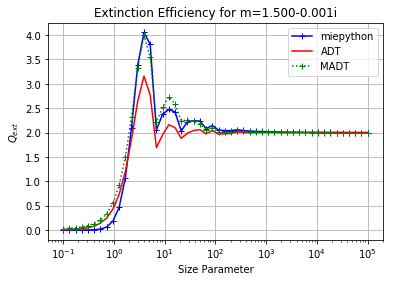

In [68]:
plt.semilogx(x, qext, 'b-+', label="miepython")
plt.semilogx(x, Qext_adt(m,x), 'r', label="ADT")
plt.semilogx(x, Qext_madt(m,x), 'g+:', label="MADT")

plt.ylabel("$Q_{ext}$")

plt.xlabel("Size Parameter")
plt.title("Extinction Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

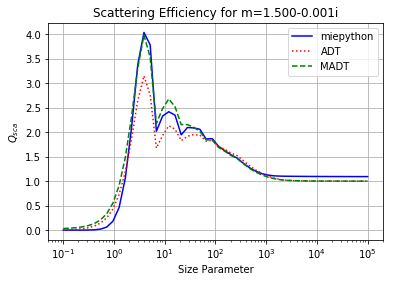

In [69]:
Qsca_adt = Qext_adt(m,x)-Qabs_adt(m,x)
Qsca_madt = Qext_madt(m,x)-Qabs_madt(m,x)

plt.semilogx(x, qsca, 'b', label="miepython")
plt.semilogx(x, Qsca_adt, 'r:', label="ADT")
plt.semilogx(x, Qsca_madt, 'g--', label="MADT")

plt.xlabel("Size Parameter")
plt.ylabel("$Q_{sca}$")
plt.title("Scattering Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

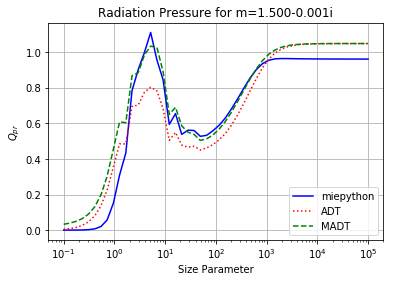

In [70]:
Qpr_adt = Qext_adt(m,x)-g*Qsca_adt
Qpr_madt = Qext_madt(m,x)-g*Qsca_madt

plt.semilogx(x, qext - g * qsca, 'b', label="miepython")
plt.semilogx(x, Qpr_adt, 'r:', label="ADT")
plt.semilogx(x, Qpr_madt, 'g--', label="MADT")


plt.xlabel("Size Parameter")
plt.ylabel("$Q_{pr}$")
plt.title("Radiation Pressure for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

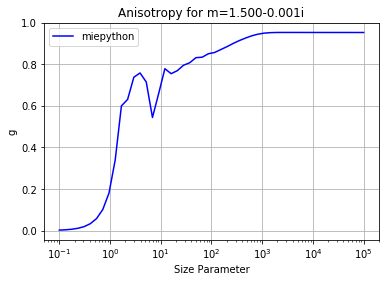

In [71]:
plt.semilogx(x, g, 'b', label="miepython")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Anisotropy for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

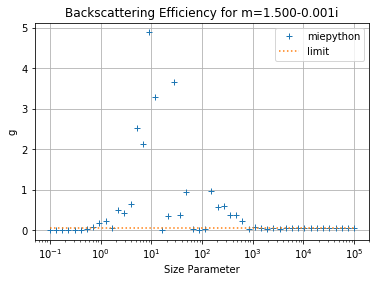

In [72]:
Qbacks = ((n-1)**2 + kappa**2)/((n+1)**2+kappa**2)
Qback = Qbacks * np.ones_like(x)

plt.semilogx(x, qback, '+', label="miepython")
plt.semilogx(x, Qback, ':', label="limit")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Backscattering Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

### Some Absorption m=1.5-0.1j

In [59]:
m = 1.5-0.1j
x = np.logspace(-1, 5, 50)  # also in microns
qext, qsca, qback, g = mp.mie(m,x)
qabs = qext-qsca

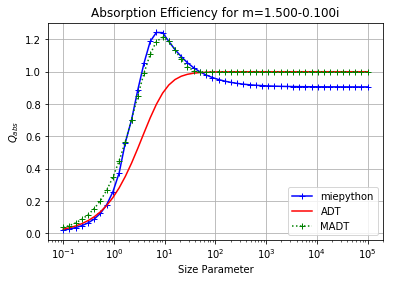

In [60]:
plt.semilogx(x, qabs, 'b-+', label="miepython")
plt.semilogx(x, Qabs_adt(m,x), 'r', label="ADT")
plt.semilogx(x, Qabs_madt(m,x), 'g+:', label="MADT")

plt.ylabel("$Q_{abs}$")

plt.xlabel("Size Parameter")
plt.title("Absorption Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

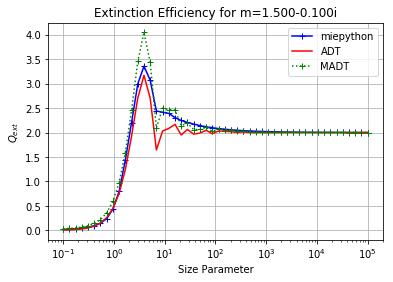

In [61]:
plt.semilogx(x, qext, 'b-+', label="miepython")
plt.semilogx(x, Qext_adt(m,x), 'r', label="ADT")
plt.semilogx(x, Qext_madt(m,x), 'g+:', label="MADT")

plt.ylabel("$Q_{ext}$")

plt.xlabel("Size Parameter")
plt.title("Extinction Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

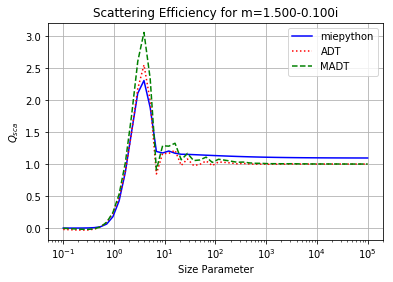

In [62]:
Qsca_adt = Qext_adt(m,x)-Qabs_adt(m,x)
Qsca_madt = Qext_madt(m,x)-Qabs_madt(m,x)

plt.semilogx(x, qsca, 'b', label="miepython")
plt.semilogx(x, Qsca_adt, 'r:', label="ADT")
plt.semilogx(x, Qsca_madt, 'g--', label="MADT")

plt.xlabel("Size Parameter")
plt.ylabel("$Q_{sca}$")
plt.title("Scattering Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

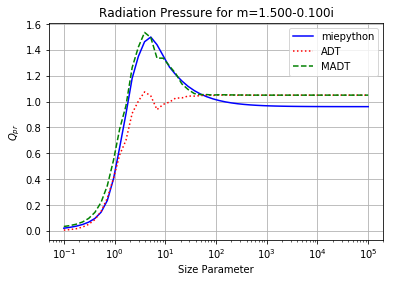

In [63]:
Qpr_adt = Qext_adt(m,x)-g*Qsca_adt
Qpr_madt = Qext_madt(m,x)-g*Qsca_madt

plt.semilogx(x, qext - g * qsca, 'b', label="miepython")
plt.semilogx(x, Qpr_adt, 'r:', label="ADT")
plt.semilogx(x, Qpr_madt, 'g--', label="MADT")


plt.xlabel("Size Parameter")
plt.ylabel("$Q_{pr}$")
plt.title("Radiation Pressure for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

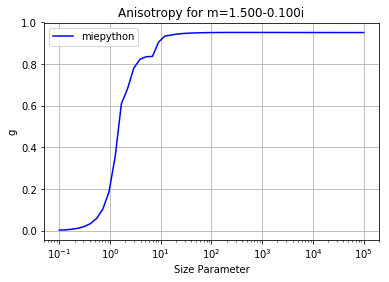

In [64]:
plt.semilogx(x, g, 'b', label="miepython")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Anisotropy for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

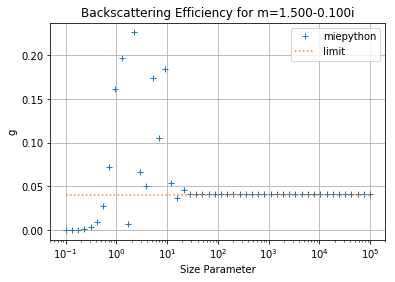

In [65]:
Qbacks = ((n-1)**2 + kappa**2)/((n+1)**2+kappa**2)
Qback = Qbacks * np.ones_like(x)

plt.semilogx(x, qback, '+', label="miepython")
plt.semilogx(x, Qback, ':', label="limit")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Backscattering Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

### A lot of absorption m=1.5-1j

In [73]:
m = 1.5-1j
x = np.logspace(-1, 5, 50)  # also in microns
qext, qsca, qback, g = mp.mie(m,x)
qabs = qext-qsca

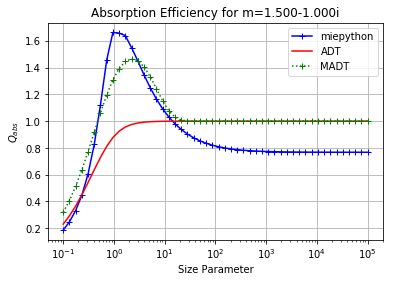

In [74]:
plt.semilogx(x, qabs, 'b-+', label="miepython")
plt.semilogx(x, Qabs_adt(m,x), 'r', label="ADT")
plt.semilogx(x, Qabs_madt(m,x), 'g+:', label="MADT")

plt.ylabel("$Q_{abs}$")

plt.xlabel("Size Parameter")
plt.title("Absorption Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

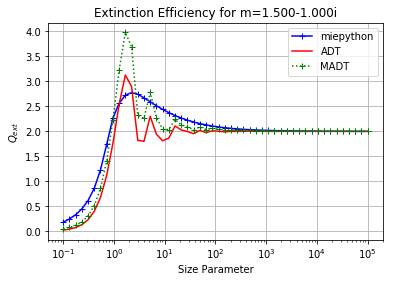

In [75]:
plt.semilogx(x, qext, 'b-+', label="miepython")
plt.semilogx(x, Qext_adt(m,x), 'r', label="ADT")
plt.semilogx(x, Qext_madt(m,x), 'g+:', label="MADT")

plt.ylabel("$Q_{ext}$")

plt.xlabel("Size Parameter")
plt.title("Extinction Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

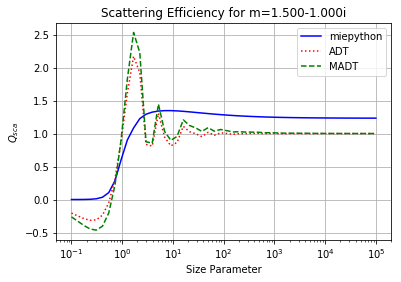

In [76]:
Qsca_adt = Qext_adt(m,x)-Qabs_adt(m,x)
Qsca_madt = Qext_madt(m,x)-Qabs_madt(m,x)

plt.semilogx(x, qsca, 'b', label="miepython")
plt.semilogx(x, Qsca_adt, 'r:', label="ADT")
plt.semilogx(x, Qsca_madt, 'g--', label="MADT")

plt.xlabel("Size Parameter")
plt.ylabel("$Q_{sca}$")
plt.title("Scattering Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

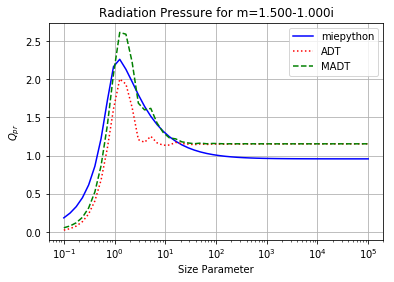

In [77]:
Qpr_adt = Qext_adt(m,x)-g*Qsca_adt
Qpr_madt = Qext_madt(m,x)-g*Qsca_madt

plt.semilogx(x, qext - g * qsca, 'b', label="miepython")
plt.semilogx(x, Qpr_adt, 'r:', label="ADT")
plt.semilogx(x, Qpr_madt, 'g--', label="MADT")


plt.xlabel("Size Parameter")
plt.ylabel("$Q_{pr}$")
plt.title("Radiation Pressure for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

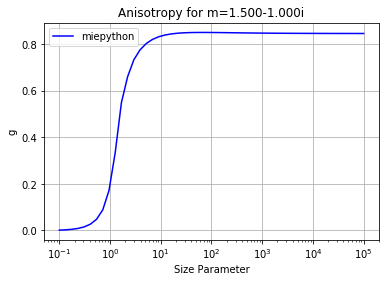

In [78]:
plt.semilogx(x, g, 'b', label="miepython")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Anisotropy for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

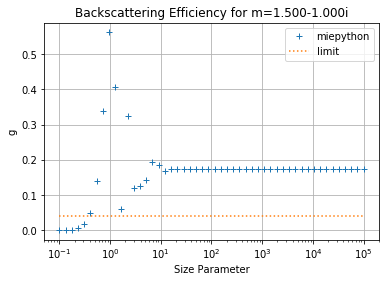

In [79]:
Qbacks = ((n-1)**2 + kappa**2)/((n+1)**2+kappa**2)
Qback = Qbacks * np.ones_like(x)

plt.semilogx(x, qback, '+', label="miepython")
plt.semilogx(x, Qback, ':', label="limit")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Backscattering Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

# Testing Backscattering 

For large spheres with absorption, backscattering efficiency should just be equal to the reflection for perpendicular light on a planar surface.

In [ ]:
x = np.logspace(1, 5, 20)  # also in microns

kappa=1
m = 1.5 - kappa*1j
R = abs(m-1)**2/abs(m+1)**2
Qbig = R * np.ones_like(x)

qext, qsca, qback, g = mp.mie(m,x)
plt.semilogx(x, qback, '+')
plt.semilogx(x, Qbig, ':')
plt.text(x[-1],Qbig[-1],"$\kappa$=%.3f" % kappa,va="bottom",ha='right')

kappa=0.001
m = 1.5 - kappa*1j
R = abs(m-1)**2/abs(m+1)**2
Qbig = R * np.ones_like(x)

qext, qsca, qback, g = mp.mie(m,x)
plt.semilogx(x, qback, '+')
plt.semilogx(x, Qbig, ':')
plt.text(x[-1],Qbig[-1],"$\kappa$=%.3f" % kappa,va="bottom",ha='right')

plt.ylim(0,0.2)
plt.title("Backscattering Efficiency for m=1.5 - i $\kappa$")
plt.xlabel("Size Parameter")
plt.ylabel("$Q_{back}$")
plt.grid()